# COVID-19 modelling for Italy
Autor: Taco de Wolff\
Fecha: 27 abril 2020

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano

import epidemia

# Train model parameters
Using data from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [2]:
df_confirmed = pd.read_csv('../data/csse_confirmed.csv')
df_confirmed.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_confirmed = df_confirmed.groupby('Country/Region').sum()
df_confirmed = df_confirmed.transpose()
df_confirmed.index = pd.to_datetime(df_confirmed.index)

df_recovered = pd.read_csv('../data/csse_recovered.csv')
df_recovered.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_recovered = df_recovered.groupby('Country/Region').sum()
df_recovered = df_recovered.transpose()
df_recovered.index = pd.to_datetime(df_recovered.index)

df_deaths = pd.read_csv('../data/csse_deaths.csv')
df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_deaths = df_deaths.groupby('Country/Region').sum()
df_deaths = df_deaths.transpose()
df_deaths.index = pd.to_datetime(df_deaths.index)

data = pd.DataFrame({
    'I_cases': df_confirmed['Italy'],
    'R': df_recovered['Italy'],
    'D': df_deaths['Italy'],
})

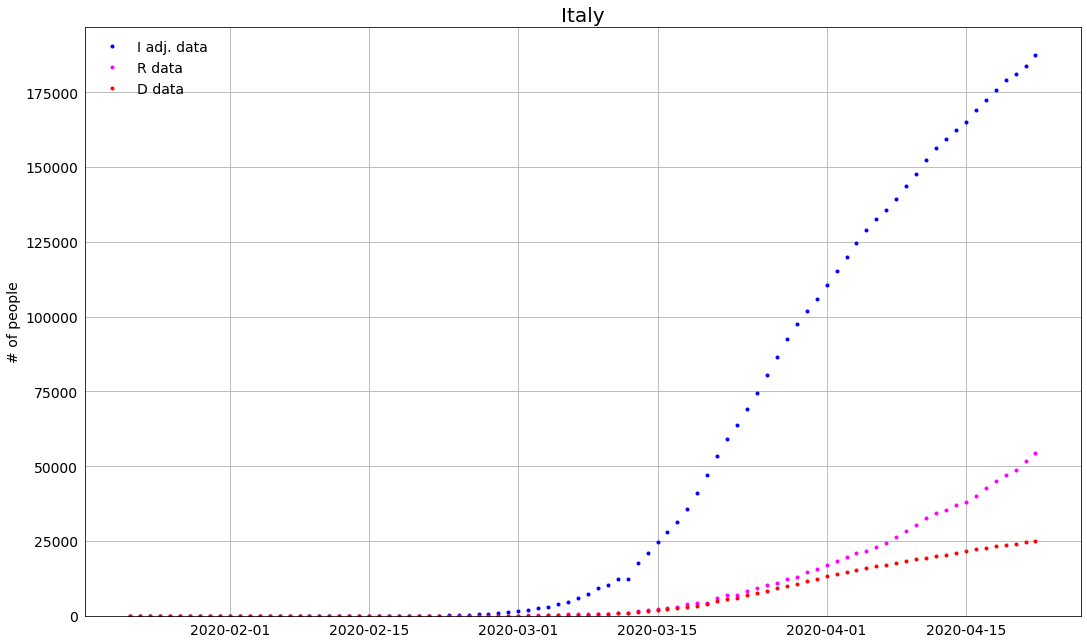

In [3]:
fig = plt.figure(figsize=(15,9))
plt.title('Italy', fontsize=20)

plt.plot(data.index, data['I_cases'], ls='none', marker='.', color='blue', label='I adj. data');
plt.plot(data.index, data['R'], ls='none', marker='.', color='magenta', label='R data');
plt.plot(data.index, data['D'], ls='none', marker='.', color='red', label='D data');

plt.ylabel("# of people", fontsize=14)
plt.ylim(0, None)
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.legend(frameon=False, prop={'size': 14})
plt.tight_layout()
plt.grid()
plt.tick_params(bottom=False, top=False, left=False, right=False, labelsize=14)

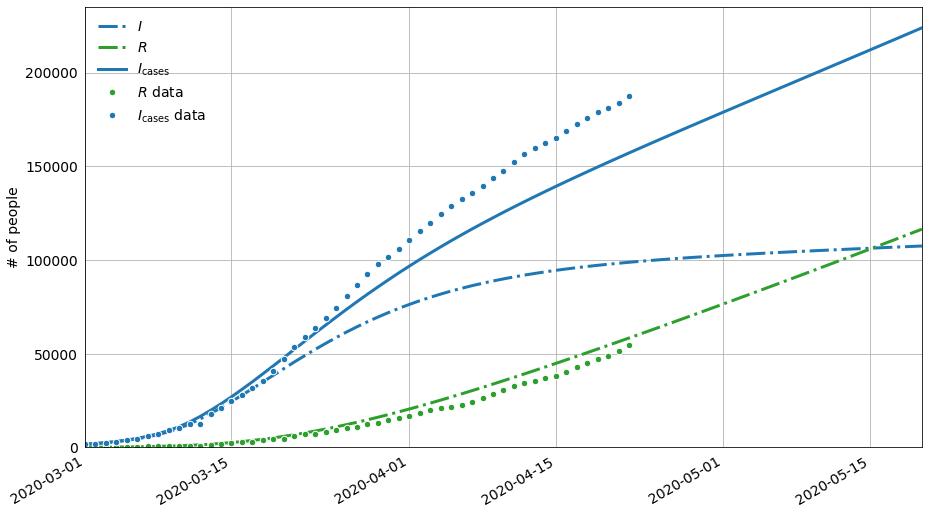

,*,R,I_cases
N,106,53,53
AE,832424,119398,713026
SE,1.82438e+10,4.58449e+08,1.77854e+10
APE,14.825,8.47347,6.35156
SPE,2.66132,1.66378,0.997547
MAE,7853.06,2252.79,13453.3
MSE,1.72111e+08,8.64998e+06,3.35573e+08
MAPE,0.139859,0.159877,0.119841
MSPE,0.0251068,0.031392,0.0188216


In [4]:
t0 = np.datetime64('2020-03-01')
model = epidemia.SIR()

I0 = data['I_cases'].loc[t0]
R0 = data['R'].loc[t0]

x0 = [
    0.22,  # β
    0.02,  # γ
    0.1,   # α2
    0.1,   # κ
]

x_bounds = [
    (0.0,1.0),
    (0.0,1.0),
    (0.0,1.0),
    (0.05,0.15),
]

def x_params(β, γ, α2, κ):
    y0 = {
        'S': 1.39e9,
        'I': I0,
        'R': R0,
    }
    
    λ = np.datetime64('2020-03-11')
    day = np.timedelta64(1,'D')
    α = lambda t: 1.0 if t < λ else α2 + (1.0-α2) * np.exp(-κ*(t-λ)/day)
    return y0, lambda t: {
        'β': α(t)*β,
        'γ': γ,
        'μb': 0,
        'μd': 0,
    }

epidemic = epidemia.Epidemic(model, t0, tmax=80, data=data)
epidemic.run(*x_params(*x0))
epidemic.plot(cols=['I', 'R', 'I_cases'])
epidemic.error()

In [ ]:
x_sigma = [
    0.3,
    0.3,
    0.3,
    0.01,
]

def x_params(β, γ, α2, κ):
    y0 = {
        'S': 1.39e9,
        'I': I0,
        'R': R0,
    }
    
    λ = np.datetime64('2020-03-11').astype(theano.config.floatX)
    day = np.timedelta64(1,'D').astype(theano.config.floatX)
    α = lambda t: 1.0 if theano.tensor.lt(t, λ) else α2 + (1.0-α2) * np.exp(-κ*(t-λ)/day)
    return y0, lambda t: {
        'β': α(t)*β,
        'γ': γ,
        'μb': 0,
        'μd': 0,
    }

epidemic.optimize_MCMC(x0, x_bounds, x_params, x_sigma)

diffeq
model
vars
sigma
model


In [ ]:
x = x0
for method in ['PSO']:
    x = epidemic.optimize(x, x_bounds, x_params, method=method, fast=True)

epidemic.plot(cols=['I', 'R', 'I_cases'])

In [ ]:
epidemic.error()